In [1]:
import torch
import ST
from torchvision.models import resnet50
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# DETR

In [3]:
class DETR (torch.nn.Module):
    def __init__ (
        self,
        num_classes,
        hidden_dim,
        nheads,
        num_encoder_layers,
        num_decoder_layers,
    ):
        super().__init__()

        self.backbone = torch.nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
        self.conv = torch.nn.Conv2d(in_channels=2048,
                                    out_channels = hidden_dim,
                                    kernel_size = 1)
        self.transformer = torch.nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        self.linear_class = torch.nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = torch.nn.Linear(hidden_dim, 4)
        self.query_pos = torch.nn.Parameter(torch.rand(100,  hidden_dim))
        self.row_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone(inputs)
        h = self.conv(x)
        H, W = h.shape[-2:]
        pos = torch.cat((
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1)
        ), dim =-1).flatten(0, 1).unsqueeze(1)
        h = self.transformer(pos + h.flatten(2).permute(2, 0, 1),
                            self.query_pos.unsqueeze(1))
        return self.linear_class(h).squeeze(), self.linear_bbox(h).sigmoid().squeeze()

In [4]:
detr = DETR(num_classes=1,
            hidden_dim=256,
            nheads=8,
            num_encoder_layers=6,
            num_decoder_layers=6).to(device)

C:\Users\vital\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vital\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\vital\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_spar

### Getting detection dataset

In [5]:
images = torch.load('Saved Tensors/Augmented images.pth')
bboxes = torch.load('Saved Tensors/bboxes.pth')
classes = torch.load('Saved Tensors/classes.pth')

In [6]:
train_images = images[:950].to(device)
val_images = images[950:].to(device)
train_bboxes = bboxes[:950].to(device)
val_bboxes = bboxes[950:].to(device)
train_classes = classes[:950].to(device)
val_classes = classes[950:].to(device)

# Training

In [7]:
num_of_epochs = 3000
batch_size = 1
learning_rate = 1e-4
scheduler_freq = 500
scheduler_gamma = 0.5

val_every = 10
show_every = 10
val_batch_size = 1

bboxes_loss = torch.nn.MSELoss()
classes_loss = torch.nn.MSELoss()

optimizer = torch.optim.SGD(detr.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = scheduler_gamma)

losses = {"train" : [], "val" : []}

In [8]:
def L1_Regularization(  # Add the result of this function to the loss calculating as follows:
            # loss = <...> + <regularizator name>.L1_Regularization()
            model,
            lamb=1e-4,
):
    l1_regularization = 0
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)
    return lamb * l1_regularization

### Training process

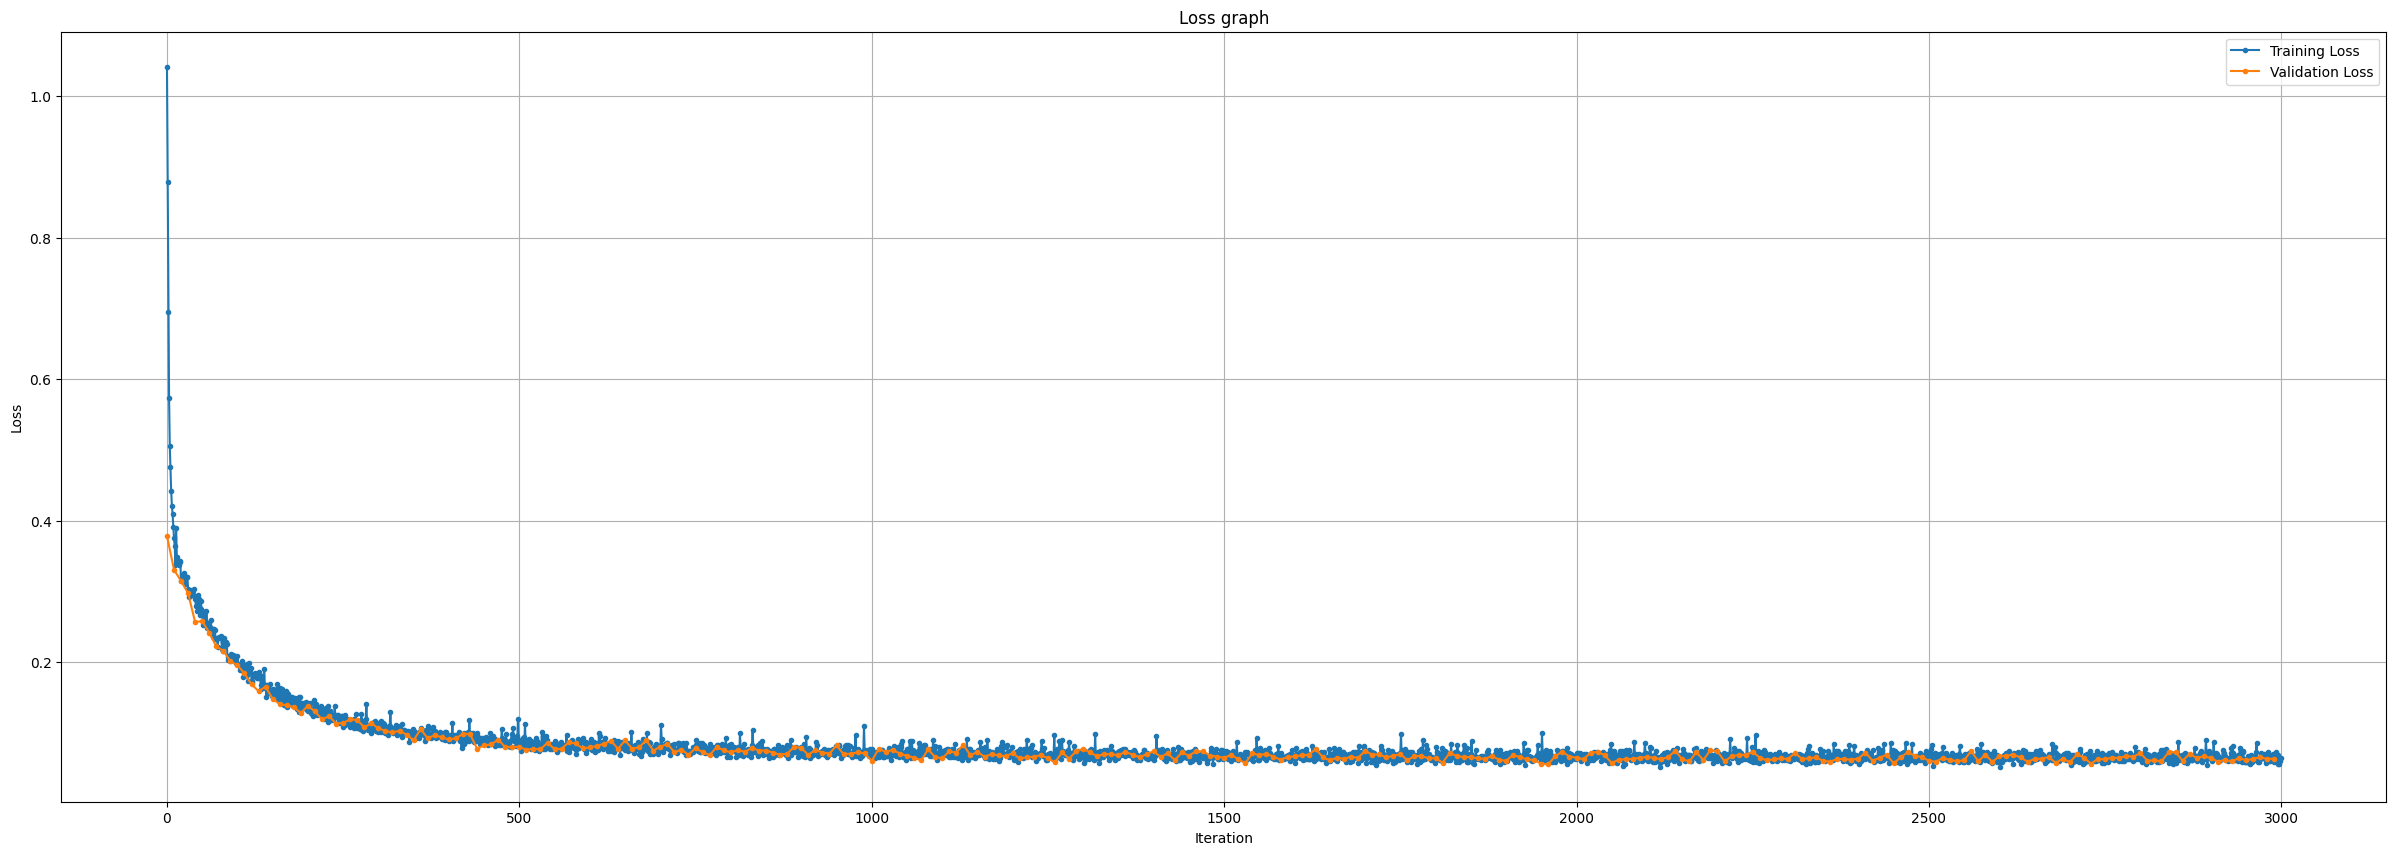

In [9]:
detr.train()

for epoch in range(1, num_of_epochs + 1):
    optimizer.zero_grad()
    batch = torch.randint(high = train_images.shape[0], size = [batch_size])

    classes_pred, bboxes_pred = detr(train_images[batch].to(device))
    loss_classes = classes_loss(classes_pred, train_classes[batch].to(device))
    loss_bboxes = bboxes_loss(bboxes_pred, train_bboxes[batch].to(device))
    general_loss = loss_classes + loss_bboxes

    general_loss.backward()
    optimizer.step()

    losses["train"].append(general_loss.item())

    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch = torch.randint(high = val_images.shape[0], size = [val_batch_size])
            
            val_classes_pred, val_bboxes_pred = detr(val_images[val_batch].to(device))
            val_loss_classes = classes_loss(val_classes_pred, val_classes[val_batch].to(device))
            val_loss_bboxes = bboxes_loss(val_bboxes_pred, val_bboxes[val_batch].to(device))
            
            val_gen_loss = val_loss_classes + val_loss_bboxes
        losses["val"].append(val_gen_loss.item())

    if epoch % show_every == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("Loss graph")
        plt.plot(losses["train"], ".-", label="Training Loss")
        plt.plot(torch.arange(0, epoch, show_every), losses["val"], ".-", label="Validation Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    if epoch % scheduler_freq == 0:
        scheduler.step()


## Using

In [17]:
def pred_perform (image):
    #detr.eval()
    image = image.unsqueeze(0)
    logits, bboxes = detr(image)
    classes = torch.zeros(logits.shape[0])

    for ind, current_pred in enumerate(logits):
        classes[ind] = torch.argmax(current_pred)

    detr.train()
    return classes, bboxes

In [20]:
pred_perform(val_images[10])

(tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
         1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
         1., 1., 0., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([[0.1420, 0.1268, 0.1712, 0.1435],
         [0.1228, 0.1251, 0.1223, 0.1462],
         [0.1417, 0.1245, 0.1172, 0.1465],
         [0.1764, 0.1432, 0.1843, 0.1114],
         [0.1430, 0.1617, 0.1046, 0.1026],
         [0.1070, 0.1353, 0.1264, 0.1462],
         [0.1499, 0.1011, 0.1478, 0.1170],
         [0.1468, 0.1238, 0.1384, 0.1519],
         [0.1745, 0.1452, 0.1301, 0.1412],
         [0.1122, 0.1447, 0.1407, 0.1149],
         [0.1177, 0.1001, 0.1421, 0.1299],
         [0.1330, 0.1613, 0.1940, 0.1601],
         [0.1178, 0.1117, 0.